In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
import cv2
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
filepath = '/home/tbranno/Downloads/train.npz'
data = np.load(filepath)
input_raw = data['input_raw_data']

In [3]:
num_seq = 100
subset_raw = input_raw[:num_seq * 20]
time_values = np.array([20000, 25000, 30000, 35000, 37500, 40000, 45000, 53000, 75000, 108000, 175000, 210000, 257000, 280000
                        , 320000, 340000, 430000, 540000, 900000, 1080000])
def comp_grain_size(image):
  _, binary = cv2.threshold((image*255).astype(np.uint8),0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  contours, _= cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  areas = [cv2.contourArea(cnt) for cnt in contours if cv2.contourArea(cnt) > 5]
  return np.mean(areas) if areas else 1e-6

all_grain_size = np.zeros((num_seq, 20))

for seq in range(num_seq):
  seq_images = subset_raw[seq*20:(seq+1)*20,0,:,:]
  grain_size = np.array([comp_grain_size(img) for img in seq_images])

  first_grain_size = max(grain_size[0],1)

  all_grain_size[seq] = grain_size/first_grain_size

x_time_log = np.tile(np.log(time_values),num_seq)
y_grain_sizes = all_grain_size.flatten()

# IQR Removal of Outliers
Q1 = np.percentile(y_grain_sizes,25)
Q3 = np.percentile(y_grain_sizes,75)
IQR = Q3-Q1
l_bound = Q1-1.5*IQR
u_bound = Q3+1.5*IQR

#Outlier filtering
allowed = (y_grain_sizes >= l_bound) & (y_grain_sizes <= u_bound)
x_filt = x_time_log[allowed]
y_filt = y_grain_sizes[allowed]

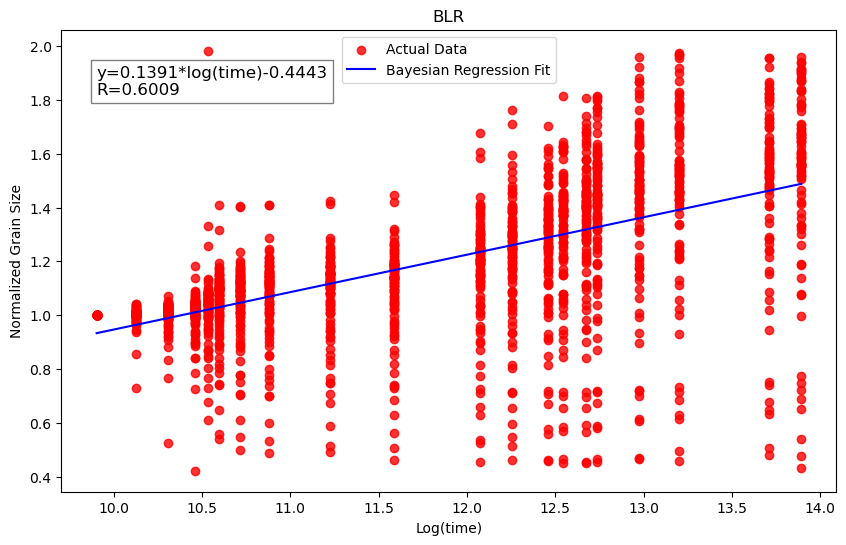

In [4]:
from scipy.stats import pearsonr
X_scaled = x_filt.reshape(-1,1)
# BLR
blr = BayesianRidge()
blr.fit(X_scaled,y_filt)
y_pred_blr = blr.predict(X_scaled)

slope = blr.coef_[0]
inter = blr.intercept_


# Actual Data

# Bayesian Linear Regression Line
pgsize = blr.predict(X_scaled)
r_val, _ = pearsonr(y_filt,pgsize)
equation = f"y={slope:.4f}*log(time){inter:.4f}\nR={r_val:.4f}"
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled, y_filt, color='red', label="Actual Data", alpha=0.8)
plt.plot(np.log(time_values),blr.predict(np.log(time_values).reshape(-1,1)),label="Bayesian Regression Fit",color = "blue")
plt.text(min(x_filt),min(y_filt)-np.log(0.25),equation,fontsize=12,verticalalignment='bottom',bbox=dict(facecolor='white',alpha=0.5))
# Labels and legend
plt.xlabel("Log(time)")
plt.ylabel("Normalized Grain Size")
plt.title(f"BLR")
plt.legend()
plt.show()

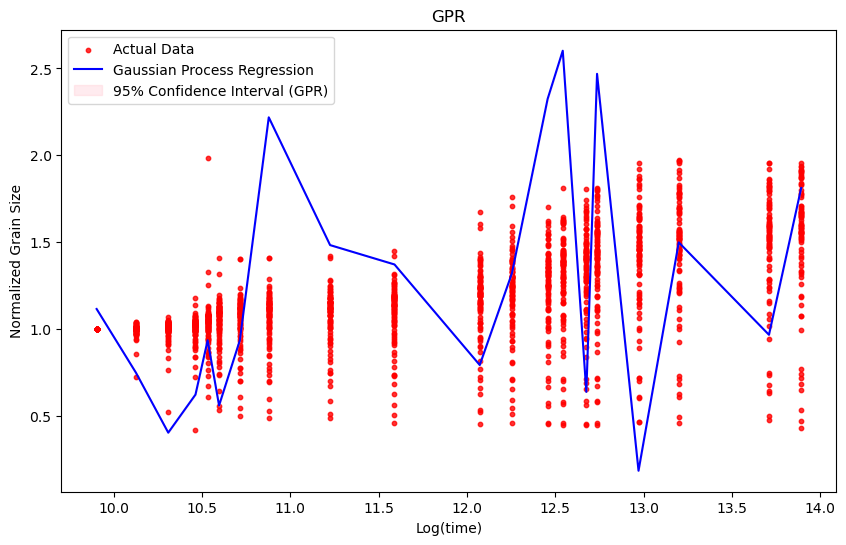

In [5]:
# GPR
kernel = C(1.0, (1e-3, 1e6)) * RBF(1.0, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gpr.fit(X_scaled, y_filt)
grain_pred_gpr, y_std = gpr.predict(np.log(time_values).reshape(-1,1), return_std=True)  # Get mean and std deviation
plt.figure(figsize=(10,6))
# Actual Data
plt.scatter(X_scaled, y_filt, color='Red', label="Actual Data", alpha=0.8,s=10)
# Gaussian Process Mean Prediction
plt.plot(np.log(time_values), grain_pred_gpr, color='blue', label="Gaussian Process Regression")

# Uncertainty Bounds (GPR)
plt.fill_between(np.log(time_values), grain_pred_gpr - 1.96 * y_std, grain_pred_gpr + 1.96 * y_std, 
                     color='pink', alpha=0.3, label="95% Confidence Interval (GPR)")
# Labels and legend
plt.xlabel("Log(time)")
plt.ylabel("Normalized Grain Size")
plt.title(f"GPR")
plt.legend()
plt.show()

In [6]:
# BLR Accuracy Metrics
r2_blr = r2_score(y_filt, y_pred_blr)
rmse_blr = np.sqrt(mean_squared_error(y_filt, y_pred_blr))

# GPR Predictions for training inputs (not test time_values, to compare fairly)
y_pred_gpr_train, _ = gpr.predict(X_scaled, return_std=True)
r2_gpr = r2_score(y_filt, y_pred_gpr_train)
rmse_gpr = np.sqrt(mean_squared_error(y_filt, y_pred_gpr_train))

# Print Results
print("Bayesian Linear Regression:")
print(f"  R² Score: {r2_blr:.4f}")
print(f"  RMSE    : {rmse_blr:.6f}")

print("\nGaussian Process Regression:")
print(f"  R² Score: {r2_gpr:.4f}")
print(f"  RMSE    : {rmse_gpr:.6f}")

Bayesian Linear Regression:
  R² Score: 0.3611
  RMSE    : 0.224883

Gaussian Process Regression:
  R² Score: -5.2815
  RMSE    : 0.705140
